In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import holidays
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
#prediction for consumer
i = 7

In [3]:
# Load data from Excel file and format reading_time to pd.datetime
def get_consumption(i):
    excel_file = f'C:\\Users\\jonas\\Documents\\Master Thesis\\household_data\\Participants\\C{i}.xlsx' 
    df = pd.read_excel(excel_file) 
    df['reading_time'] = pd.to_datetime(df['reading_time'])
    df.set_index('reading_time', inplace=True)
    first_complete_day = df.index[0].normalize() + pd.DateOffset(days=1)
    df_filtered = df[df.index >= first_complete_day]
    complete_time_index = pd.date_range(start=first_complete_day, end=df_filtered.index.max(), freq='15T')
    df_reindexed = df_filtered.reindex(complete_time_index)
    missing_timestamps = df_reindexed[df_reindexed.isna().any(axis=1)].index
    zero_consumption = df_reindexed[df_reindexed['Consumption [kWh]'] == 0]

    print(f"Missing timestamps (every 15 minutes): {len(missing_timestamps)} entries, {round(len(missing_timestamps)/len(df_reindexed)*100,2)} percent missing values")
    
    print(f"Entries with zero Consumption [kWh]: {len(zero_consumption)} entries")
    
    plt.figure(figsize=(12, 6))
    plt.plot(df_reindexed.index, df_reindexed['Consumption [kWh]'], label='Consumption [kWh]', color='blue', alpha=0.5, linewidth=0.3)
    plt.scatter(missing_timestamps, [0] * len(missing_timestamps), color='red', marker='x', label='Missing Timestamps', alpha=0.5, linewidth=0.3)
    plt.xlabel('Time')
    plt.ylabel('Consumption [kWh]')
    plt.title(f'Time Series of Consumption with Missing Timestamps Consumer {i}')
    plt.legend()
    plt.show()
    
    #create heatmap
    consumer_data = df.copy()
    consumer_data['reading_time'] = consumer_data.index
    consumer_data['reading_time'] = pd.to_datetime(consumer_data['reading_time'])
    consumer_data['hour'] = consumer_data['reading_time'].dt.hour
    consumer_data['minute'] = consumer_data['reading_time'].dt.minute
    consumer_data['day'] = consumer_data['reading_time'].dt.dayofyear
    consumer_data['quarter_hour'] = (consumer_data['hour'] * 4) + (consumer_data['minute'] // 15)
    heatmap_data = consumer_data.pivot_table(index='day', columns='quarter_hour', values='Consumption [kWh]', aggfunc='mean')
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_data, cmap='icefire', cbar_kws={'label': 'Consumption [kWh]'})
    plt.title(f'Consumer {i}: Daily Load Profile Heatmap', size=20)
    plt.xlabel('Quarter Hour of the Day', size=16)
    plt.ylabel('Day of the Year', size=16)
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.tight_layout()
    plt.savefig(f'C:\\Users\\jonas\\Documents\\Master Thesis\\household_data\\Participants\\heatmap_C{i}_quarterly.png', dpi=1000)  # Change the file extension and dpi as needed
    plt.show()
    plt.close() 
    
    # Reset the index to make reading_time a column again
    df_reindexed = df_reindexed.reset_index()
    df_reindexed.rename(columns={'index': 'reading_time'}, inplace=True)
    
    return df_reindexed
#returns the consumption data for consumer number i

In [4]:
#extract the temperture of Vila Nova de Famalicão from the csv file that was previously created using the weather notebook
def get_temperature():
    temp = pd.read_csv('C:\\Users\\jonas\\Documents\\Master Thesis\\household_data\\temperature_2023.csv') 
    temp['reading_time'] = pd.to_datetime(temp['date'])
    # Set the 'date' column as the index in the 'temp' DataFrame
    temp.set_index('reading_time', inplace=True)
    # Reformat the datetime index
    temp.index = temp.index.strftime('%Y-%m-%d %H:%M:%S')
    temp.index = pd.to_datetime(temp.index)
    return temp
#returns the temperature for Vila Nova de Famalicão for year 2023

In [5]:
# Define a function to check if a date is a holiday
def is_holiday(date):
    pt_holidays = holidays.Portugal()
    return int(date in pt_holidays)
#returns 0 if no holiday, 1 if holiday 

# Define a function to check if a day is a weekend (Saturday or Sunday)
def is_weekend(day):
    return int(day.weekday() >= 5)  # Saturday or Sunday
#returns 0 if weekday, 1 if weekend

In [6]:
def get_features(include_month=False, include_day=True, include_hour=True, include_minute=False, include_holiday=False, include_weekend=True, include_temperature=False):
    data = get_consumption(i=7)
    data['month'] = data['reading_time'].dt.month
    data['day'] = data['reading_time'].dt.dayofweek
    data['hour'] = data['reading_time'].dt.hour
    data['minute'] = data['reading_time'].dt.minute
    data['is_holiday'] = data['reading_time'].apply(is_holiday)
    data['is_weekend'] = data['reading_time'].apply(is_weekend)
    data.set_index('reading_time', inplace=True)

    data = get_preprocessed(data)
    
    temp = get_temperature()
    
    # Merge temp and data on time
    merged_data = pd.merge_asof(data, temp, left_index=True, right_index=True)
    consumption_column = merged_data['Consumption [kWh]'].values.reshape(-1, 1)
    
    # Initialize list of columns to concatenate
    feature_columns = [consumption_column]
    if include_month:
        feature_columns.append(merged_data['month'].values.reshape(-1, 1))    
    if include_day:
        feature_columns.append(merged_data['day'].values.reshape(-1, 1))    
    if include_hour:
        feature_columns.append(merged_data['hour'].values.reshape(-1, 1))
    if include_temperature:
        feature_columns.append(merged_data['temperature_2m'].values.reshape(-1, 1))
    if include_minute:
        feature_columns.append(merged_data['minute'].values.reshape(-1, 1))
    if include_holiday:
        feature_columns.append(merged_data['is_holiday'].values.reshape(-1, 1))        
    if include_weekend:
        feature_columns.append(merged_data['is_weekend'].values.reshape(-1, 1))
    
    # Concatenate the columns horizontally to create X
    X = np.concatenate(feature_columns, axis=1)
    y = merged_data['Consumption [kWh]'].values.reshape(-1, 1)
    
    return X,y

#get the feature matrix X and the shifted target variables y by calling X,y = get_feature

In [7]:
#preprocess the data such that if whole days are missing data they will be filled with the specific weekday average of the season
def get_preprocessed(data):
    # Define thresholds
    complete_day_threshold = 20  # Less than 20 timesteps missing in a day
    season_months = {
        'spring': [3, 4, 5],
        'summer': [6, 7, 8],
        'autumn': [9, 10, 11],
        'winter': [12, 1, 2]
    }
    
    # Add necessary columns
    data['month'] = data.index.month
    data['weekday'] = data.index.weekday
    data['season'] = data['month'].apply(lambda m: next(k for k, v in season_months.items() if m in v))
    data['quarter_hour'] = data.index.floor('15T').time
    
    # Compute average consumption for each 15-minute interval of each weekday in each season
    avg_profile = data.groupby(['season', 'weekday', 'quarter_hour'])['Consumption [kWh]'].mean().unstack(level=[0, 1])
    
    # Identify complete days with missing data
    data['date'] = data.index.date
    missing_days = data[data['Consumption [kWh]'].isna()].groupby('date').size()
    
    # Fill missing data
    for day, count in missing_days.items():
        day_data = data[data.index.date == day]
        
        if count >= complete_day_threshold:
            # Get the season and weekday for the missing day
            season = next(k for k, v in season_months.items() if day_data.index[0].month in v)
            weekday = day_data.index[0].weekday()
            
            # Get the average profile for that season and weekday
            avg_day_profile = avg_profile.loc[:, (season, weekday)]
            
            # Create a DataFrame with the missing day's index and the average profile
            avg_day_filled = pd.DataFrame(avg_day_profile.values, index=day_data.index, columns=['Consumption [kWh]'])
            
            # Fill the missing values with the average profile
            data.loc[day_data.index, 'Consumption [kWh]'] = avg_day_filled['Consumption [kWh]']
        else:
            # Forward fill for small gaps
            data['Consumption [kWh]'].ffill(inplace=True)
    
    # Drop temporary columns
    data.drop(columns=['date', 'month', 'weekday', 'season', 'quarter_hour'], inplace=True)
    
    plt.figure(figsize=(12, 6))
    # Plot the Consumption [kWh] timeseries in blue
    plt.plot(data.index, data['Consumption [kWh]'], label='Consumption [kWh]', color='blue', alpha=0.5, linewidth=0.3)
    # Add labels and title
    plt.xlabel('Time')
    plt.ylabel('Consumption [kWh]')
    plt.title('Time Series of Consumption with Missing Timestamps')
    plt.legend()
    # Show the plot
    plt.show()
    
    return data

    #if missing data > 1 day --> fill the day with average weekday of the season
    #if missing data < 1 day --> forward fill

In [8]:
def get_split(X, y):
    # Assuming the third column is the hour of the day (0 to 24)
    hours = X[:, 2]
    
    # Find the index of the 80% split
    initial_split_index = int(len(X) * 0.8)
    
    # Adjust to the closest midnight = 0
    # We will look for the next midnight (as we want the validation set to start at midnight)
    for i in range(initial_split_index, len(hours)):
        if hours[i] == 0 and hours[i-1] == 23:  # Adjust threshold as necessary for "midnight"
            split_index = i
            break
    
    X_train, X_val = X[:split_index], X[split_index:]
    y_train, y_val = y[:split_index], y[split_index:]
    
    return X_train, X_val, y_train, y_val

In [9]:
#get error metrics
def get_error(y_test, y_pred):
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
        r2 = r2_score(y_test, y_pred)
        results = pd.DataFrame({
            'Metric': ['RMSE', 'MAE', 'MAPE', 'R-squared'],
            'Value': [rmse, mae, mape, r2]
        })
        return results
#returns error metrics in a pd dataframe

In [10]:
def sliding_window(X, y, window_size=3*96, pred_size=96):
    X_windows = []
    y_windows = []
    step_size = pred_size  # 1 day
    
    for i in range(0, len(X) - window_size - pred_size + 1, step_size):
        # Concatenate the 3-day windows along the feature axis
        X_window = np.concatenate(
            [X[i:i + window_size // 3], 
             X[i + window_size // 3:i + 2 * window_size // 3], 
             X[i + 2 * window_size // 3:i + window_size]], 
            axis=1
        )
        X_windows.append(X_window)
        y_windows.append(y[i + window_size:i + window_size + pred_size])
    
    return np.array(X_windows), np.array(y_windows)

In [11]:
def get_model_random_forest(n_estimators=1000, criterion='mae', max_depth=None, random_state=42, verbose=2):
    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)
    return model

Missing timestamps (every 15 minutes): 5801 entries, 16.6 percent missing values
Entries with zero Consumption [kWh]: 80 entries


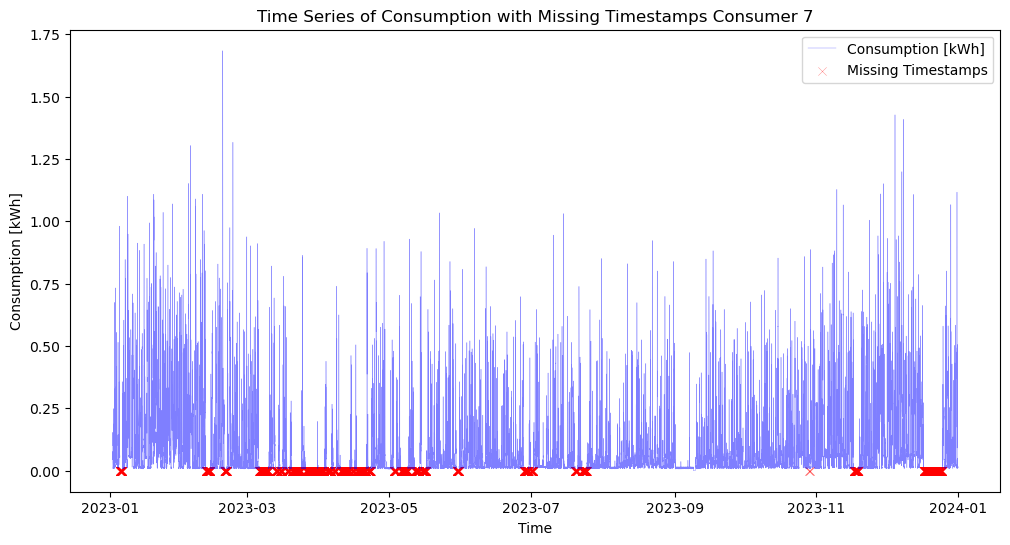

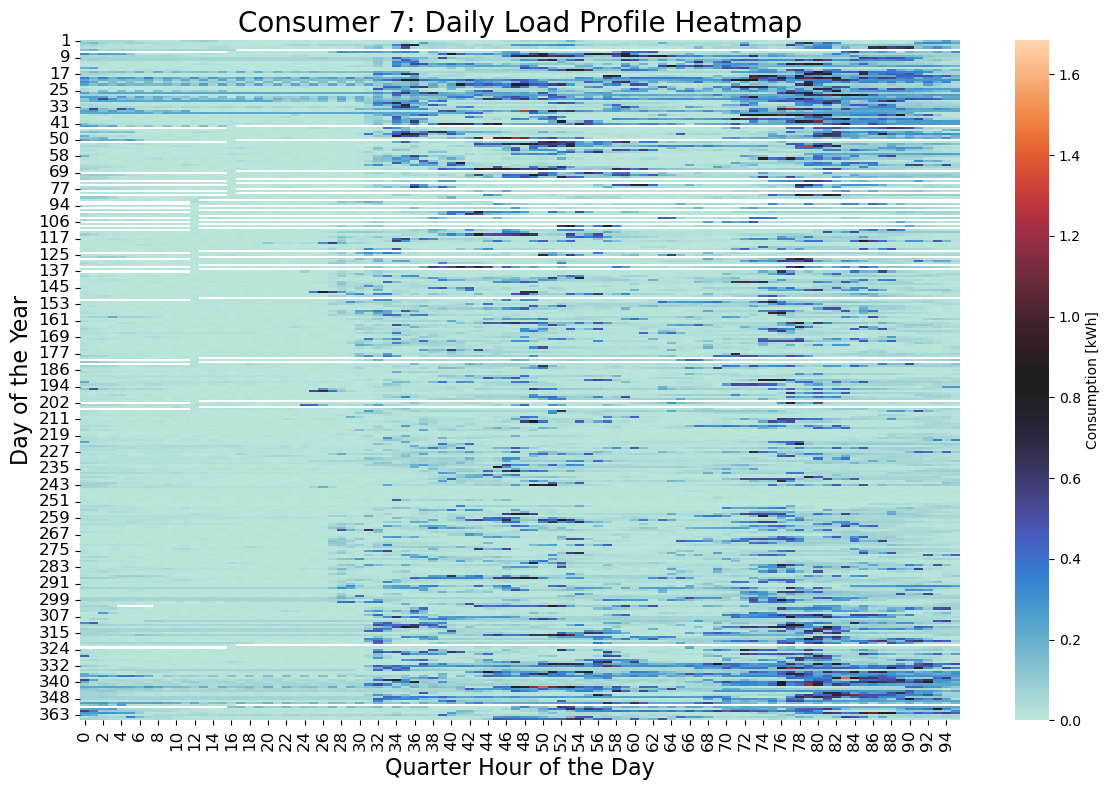

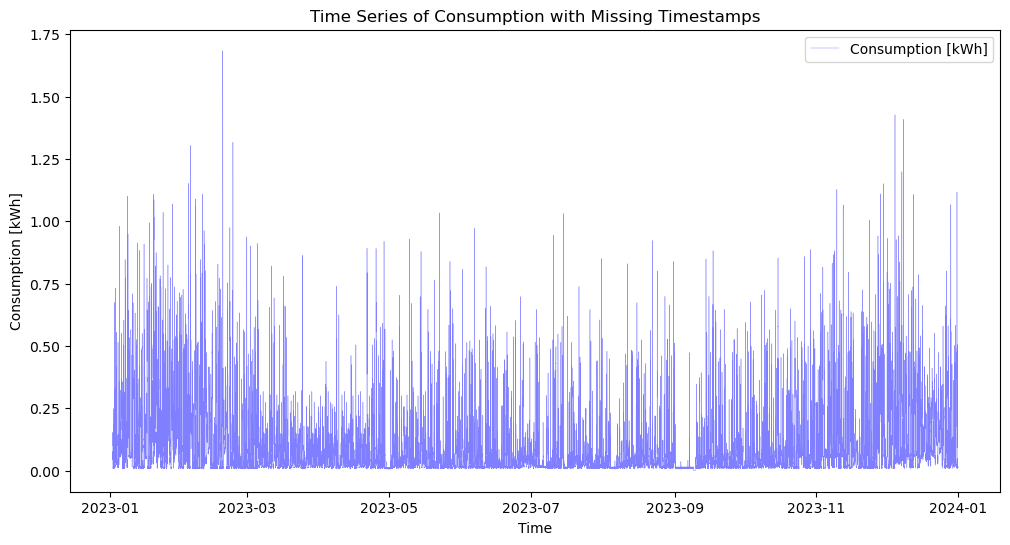

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [12]:
# For RandomForest
# Call get_features with the current combination
X, y = get_features()
X_train, X_val, y_train, y_val = get_split(X,y)
X_train_window, y_train_window = sliding_window(X_train,y_train)
X_val_window, y_val_window = sliding_window(X_val,y_val)

model_rf = get_model_random_forest()
for n in range(len(X_train_window)):
    print(n)
    history = model_rf.fit(X_train_window[n], y_train_window[n].ravel())

y_val_pred = []
for k in range(len(X_val_window)):
    y_pred = model_rf.predict(X_val_window[k])
    y_val_pred.append(y_pred)
    
y_val_pred = np.array(y_val_pred)
y_val_window_reshaped = y_val_window.reshape((y_val_window.shape[0], y_val_window.shape[1]))

In [13]:
results = get_error(y_val_window_reshaped, y_val_pred)
results.to_csv(f'C:\\Users\\jonas\\Documents\\Master Thesis\\household_data\\Prediction\\C{i}\\performance_metrics_RFR_C{i}.csv')
print(results)

      Metric       Value
0       RMSE    0.173925
1        MAE    0.133597
2       MAPE  411.246448
3  R-squared   -3.846433


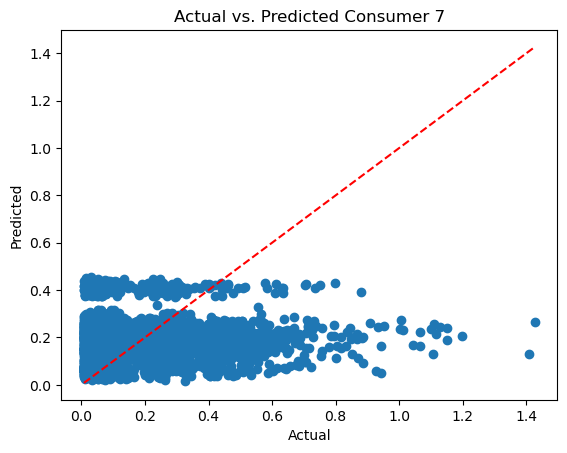

In [14]:
# Plot actual vs. predicted values
plt.scatter(y_val_window_reshaped, y_val_pred)
plt.plot([min(y_val_window.flatten()), max(y_val_window.flatten())], [min(y_val_window.flatten()), max(y_val_window.flatten())], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Actual vs. Predicted Consumer {i}')
plt.savefig(f'C:\\Users\\jonas\\Documents\\Master Thesis\\household_data\\Prediction\\C{i}\\R_score_RFR_C{i}.png', dpi=300)
plt.show()

KeyboardInterrupt: 

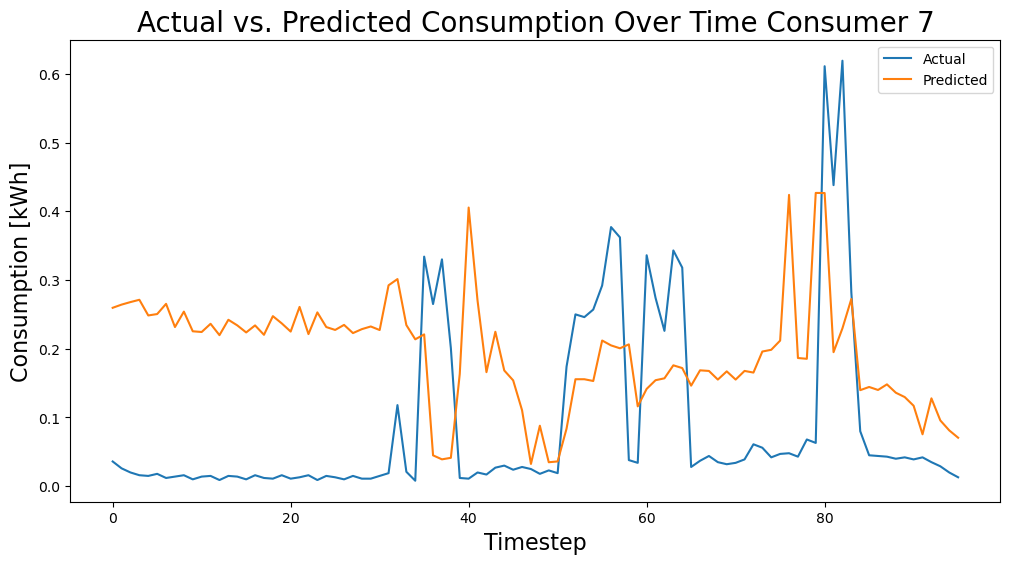

In [15]:
# Time series plot (if applicable)
k=20
#specify the day
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_val_pred[k])), y_val_window_reshaped[k], label='Actual')
plt.plot(range(len(y_val_pred[k])), y_val_pred[k], label='Predicted')
plt.xlabel('Timestep', size=16)
plt.ylabel('Consumption [kWh]', size=16)
plt.title(f'Actual vs. Predicted Consumption Over Time Consumer {i}', size=20)
plt.legend()
plt.savefig(f'C:\\Users\\jonas\\Documents\\Master Thesis\\household_data\\Prediction\\C{i}\\day_timeseries_RFR_C{i}.png', dpi=1000)
plt.show()

In [ ]:
# Time series plot (if applicable)
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_val_pred.flatten())), y_val_window_reshaped.flatten(), label='Actual')
plt.plot(range(len(y_val_pred.flatten())), y_val_pred.flatten(), label='Predicted')
plt.xlabel('Timestep', size=16)
plt.ylabel('Consumption [kWh]', size=16)
plt.title(f'Actual vs. Predicted Consumption Over Time Consumer {i}', size=20)
plt.legend()
plt.savefig(f'C:\\Users\\jonas\\Documents\\Master Thesis\\household_data\\Prediction\\C{i}\\all_timeseries_RFR_C{i}.png', dpi=1000)
plt.show()

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming get_features, get_split, sliding_window, and get_model_random_forest are defined functions

# Step 1: Get the features and split the data
X, y = get_features()
X_train, X_val, y_train, y_val = get_split(X, y)
X_train_window, y_train_window = sliding_window(X_train, y_train)
X_val_window, y_val_window = sliding_window(X_val, y_val)

# Step 2: Define the parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [200, 500, 1000, 2000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, 30, 40, 50, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Step 3: Initialize the RandomForestRegressor
model_rf = RandomForestRegressor()

# Step 4: Use RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(estimator=model_rf, param_distributions=param_grid,
                                   n_iter=100, cv=2, verbose=2, random_state=42, n_jobs=-1)

# Step 5: Fit RandomizedSearchCV
for n in range(len(X_train_window)):
    random_search.fit(X_train_window[n], y_train_window[n].ravel())

# Step 6: Get the best parameters and train the model with them
best_model_rf = random_search.best_estimator_

# Train the model on each sliding window
for n in range(len(X_train_window)):
    best_model_rf.fit(X_train_window[n], y_train_window[n].ravel())

# Step 7: Validate the model on the validation set
y_val_pred = []
for k in range(len(X_val_window)):
    y_pred = best_model_rf.predict(X_val_window[k])
    y_val_pred.append(y_pred)

# Step 8: Evaluate the model
y_val_pred = np.array(y_val_pred)
y_val_window_reshaped = y_val_window.reshape((y_val_window.shape[0], y_val_window.shape[1]))

# Assuming you want to evaluate with Mean Squared Error
mse = mean_squared_error(y_val_window_reshaped, y_val_pred)
print(f"Mean Squared Error on validation set: {mse}")

Missing timestamps (every 15 minutes): 5801 entries, 16.6 percent missing values
Entries with zero Consumption [kWh]: 80 entries


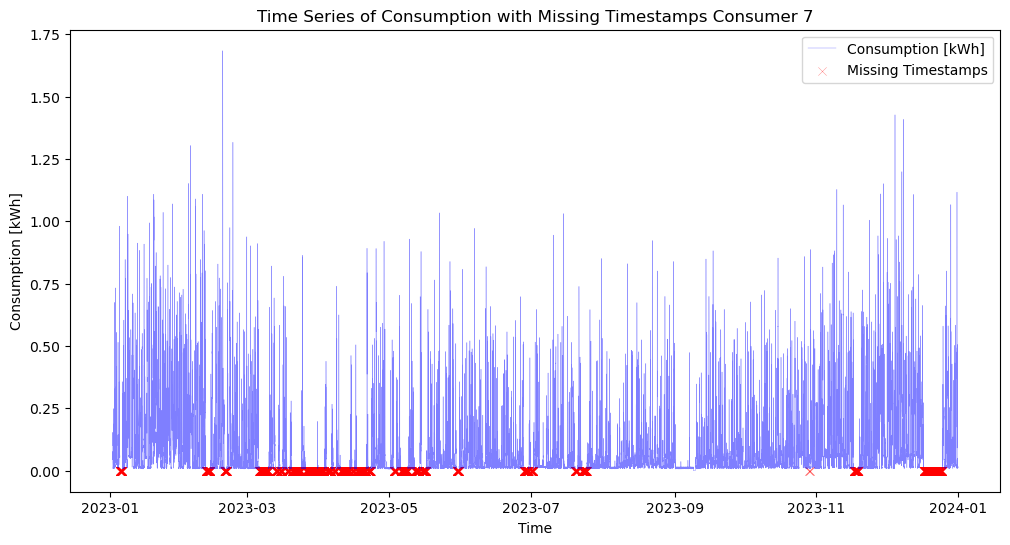

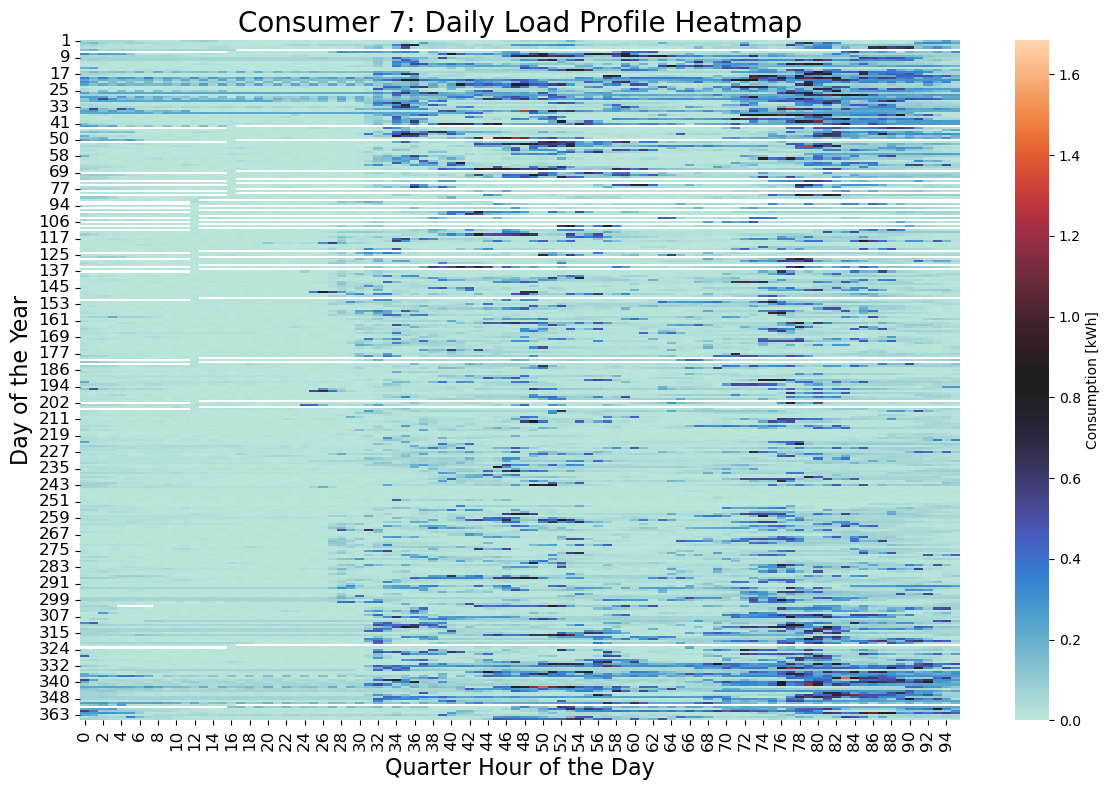

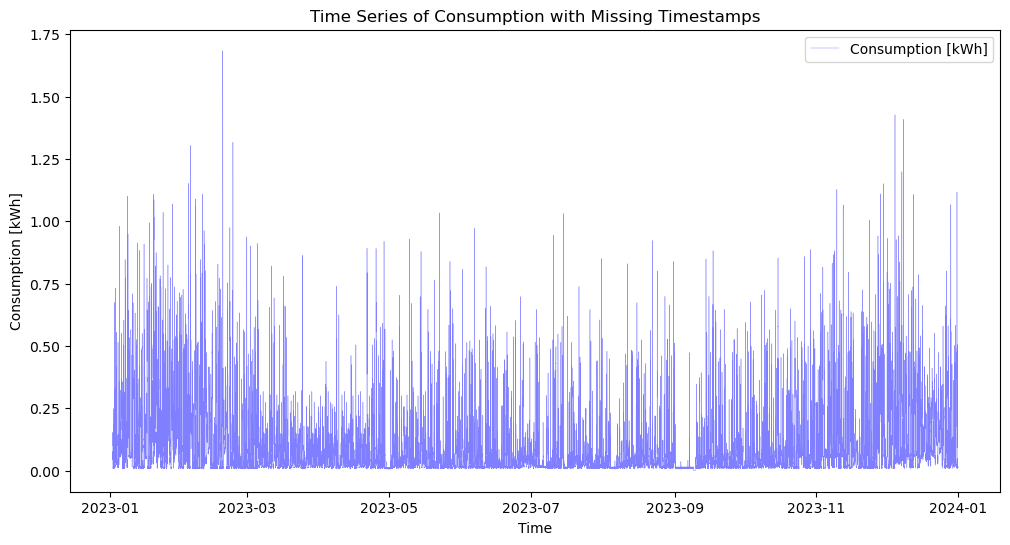

In [16]:
X, y = get_features()

In [17]:
get_split(X,y)

(array([[ 0.1  ,  0.   ,  0.   ,  0.   ],
        [ 0.154,  0.   ,  0.   ,  0.   ],
        [ 0.064,  0.   ,  0.   ,  0.   ],
        ...,
        [ 0.068,  4.   , 23.   ,  0.   ],
        [ 0.066,  4.   , 23.   ,  0.   ],
        [ 0.054,  4.   , 23.   ,  0.   ]]),
 array([[2.1e-02, 5.0e+00, 0.0e+00, 1.0e+00],
        [1.6e-02, 5.0e+00, 0.0e+00, 1.0e+00],
        [1.5e-02, 5.0e+00, 0.0e+00, 1.0e+00],
        ...,
        [1.2e-02, 6.0e+00, 2.3e+01, 1.0e+00],
        [1.3e-02, 6.0e+00, 2.3e+01, 1.0e+00],
        [1.6e-02, 6.0e+00, 2.3e+01, 1.0e+00]]),
 array([[0.1  ],
        [0.154],
        [0.064],
        ...,
        [0.068],
        [0.066],
        [0.054]]),
 array([[0.021],
        [0.016],
        [0.015],
        ...,
        [0.012],
        [0.013],
        [0.016]]))